In [7]:
# STEP 1: Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
#STEP 2: Load and Combine Datasets

from google.colab import files
uploaded = files.upload()

df1 = pd.read_csv("coin_gecko_2022-03-16.csv")
df2 = pd.read_csv("coin_gecko_2022-03-17.csv")


Saving coin_gecko_2022-03-17.csv to coin_gecko_2022-03-17.csv
Saving coin_gecko_2022-03-16.csv to coin_gecko_2022-03-16.csv


In [9]:
# Merge both days' data

df = pd.concat([df1, df2], ignore_index=True)

In [10]:
# Preview shape and structure

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (1000, 9)
Columns: ['coin', 'symbol', 'price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'date']


In [11]:
# Display the first few rows

print(df.head())

       coin symbol         price     1h    24h     7d    24h_volume  \
0   Bitcoin    BTC  40859.460000  0.022  0.030  0.055  3.539076e+10   
1  Ethereum    ETH   2744.410000  0.024  0.034  0.065  1.974870e+10   
2    Tether   USDT      1.000000 -0.001 -0.001  0.000  5.793497e+10   
3       BNB    BNB    383.430000  0.018  0.028  0.004  1.395854e+09   
4  USD Coin   USDC      0.999874 -0.001  0.000 -0.000  3.872274e+09   

        mkt_cap        date  
0  7.709915e+11  2022-03-16  
1  3.271044e+11  2022-03-16  
2  7.996516e+10  2022-03-16  
3  6.404382e+10  2022-03-16  
4  5.222214e+10  2022-03-16  


In [12]:
#Summary statistics

print(df.describe())

              price          1h         24h          7d    24h_volume  \
count  1.000000e+03  993.000000  993.000000  992.000000  9.930000e+02   
mean   6.561060e+02    0.009723    0.023737    0.023558  2.893109e+08   
std    4.584655e+03    0.026934    0.059303    0.229781  2.769908e+09   
min    1.484000e-09   -0.704000   -0.646000   -0.558000  0.000000e+00   
25%    1.940547e-01    0.001000    0.001000   -0.041000  1.766976e+06   
50%    1.095000e+00    0.006000    0.016000   -0.000500  8.343005e+06   
75%    7.232500e+00    0.019000    0.035000    0.037000  4.003652e+07   
max    4.121727e+04    0.095000    0.577000    4.608000  5.793497e+10   

            mkt_cap  
count  1.000000e+03  
mean   3.755304e+09  
std    3.803783e+10  
min    6.577043e+07  
25%    1.157776e+08  
50%    2.120036e+08  
75%    5.948436e+08  
max    7.760774e+11  


In [13]:
# Basic info

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        1000 non-null   object 
 1   symbol      1000 non-null   object 
 2   price       1000 non-null   float64
 3   1h          993 non-null    float64
 4   24h         993 non-null    float64
 5   7d          992 non-null    float64
 6   24h_volume  993 non-null    float64
 7   mkt_cap     1000 non-null   float64
 8   date        1000 non-null   object 
dtypes: float64(6), object(3)
memory usage: 70.4+ KB
None


In [14]:
# Set options to display all rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Display the entire DataFrame

print(df)

                                            coin     symbol         price  \
0                                        Bitcoin        BTC  4.085946e+04   
1                                       Ethereum        ETH  2.744410e+03   
2                                         Tether       USDT  1.000000e+00   
3                                            BNB        BNB  3.834300e+02   
4                                       USD Coin       USDC  9.998740e-01   
5                                            XRP        XRP  7.850180e-01   
6                                          Terra       LUNA  8.951000e+01   
7                                         Solana        SOL  8.561000e+01   
8                                        Cardano        ADA  8.241610e-01   
9                                       Polkadot        DOT  1.855000e+01   
10                                     Avalanche       AVAX  7.369000e+01   
11                                   Binance USD       BUSD  1.000000e+00   

In [15]:
# STEP 3: CLEANING & PREPROCESSING

# Rename columns for clarity

df.rename(columns={
    '24h_volume': 'volume',
    'mkt_cap': 'market_cap',
    '24h': 'price_change_24h',
    '1h': 'price_change_1h',
    '7d': 'price_change_7d'
}, inplace=True)


#Drop irrelevant columns (symbol)

df.drop(columns=['symbol'], inplace=True, errors='ignore')


#Handle missing values with ffill() and bfill()

df.ffill(inplace=True)
df.bfill(inplace=True)


#Convert numeric columns (price, volume, market_cap)

numeric_cols = ['price', 'volume', 'market_cap']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Fill missing values

df.ffill(inplace=True)
df.bfill(inplace=True)


#Normalize features using MinMaxScaler

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [16]:
# STEP 4: FEATURE ENGINEERING


df['liquidity_ratio'] = df['volume'] / (df['market_cap'] + 1e-9)
df['price_change_pct'] = df['price_change_24h'] / (df['price'] + 1e-6)
df['price_ma_3'] = df['price'].rolling(window=3).mean()
df['volume_ma_3'] = df['volume'].rolling(window=3).mean()
df['price_volatility_3'] = df['price'].rolling(window=3).std()
df.bfill(inplace=True)


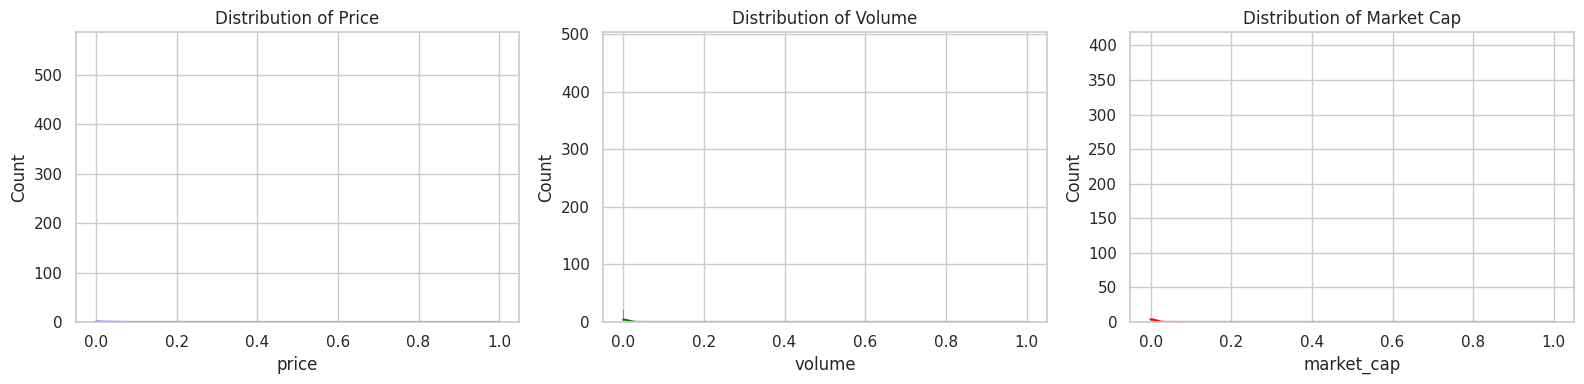

In [17]:
# STEP 5: EDA (CORRELATION HEATMAP)

# Set style
sns.set(style="whitegrid")

# Distribution Plots

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['price'], kde=True, color='blue')
plt.title('Distribution of Price')

plt.subplot(1, 3, 2)
sns.histplot(df['volume'], kde=True, color='green')
plt.title('Distribution of Volume')

plt.subplot(1, 3, 3)
sns.histplot(df['market_cap'], kde=True, color='red')
plt.title('Distribution of Market Cap')

plt.tight_layout()
plt.show()



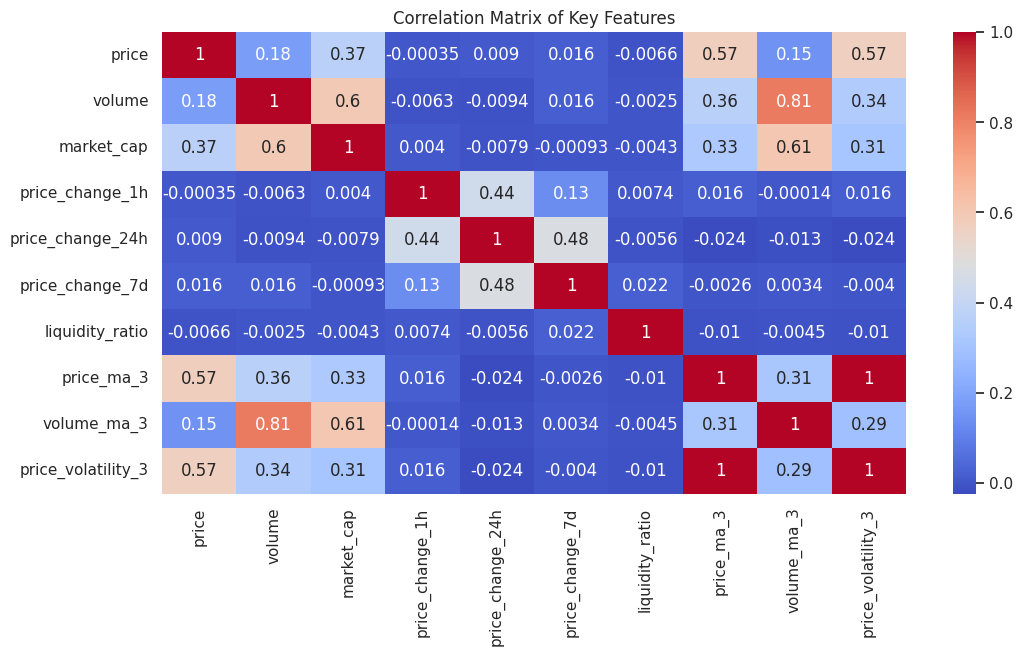

In [18]:
# Correlation Heatmap

features = ['price', 'volume', 'market_cap', 'price_change_1h',
            'price_change_24h', 'price_change_7d', 'liquidity_ratio',
            'price_ma_3', 'volume_ma_3', 'price_volatility_3']

plt.figure(figsize=(12, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Key Features")
plt.show()

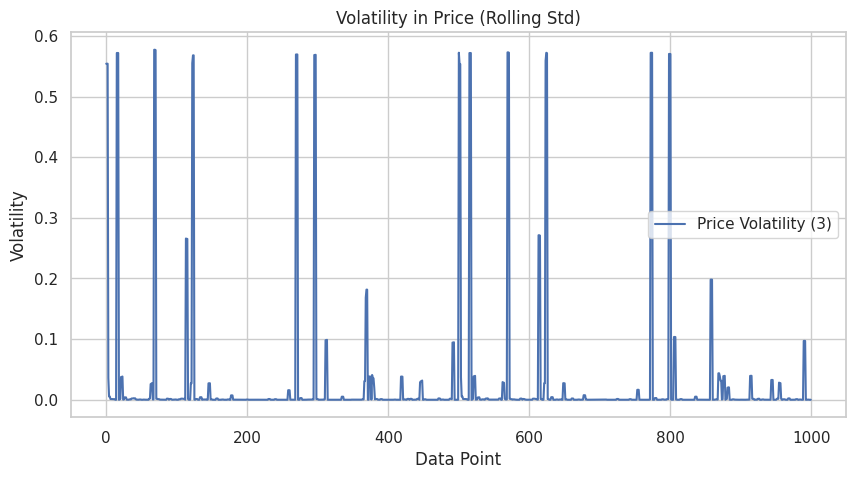

In [19]:
#  Volatility Trend Plot

plt.figure(figsize=(10, 5))
sns.lineplot(data=df['price_volatility_3'], label='Price Volatility (3)')
plt.title('Volatility in Price (Rolling Std)')
plt.xlabel('Data Point')
plt.ylabel('Volatility')
plt.legend()
plt.show()

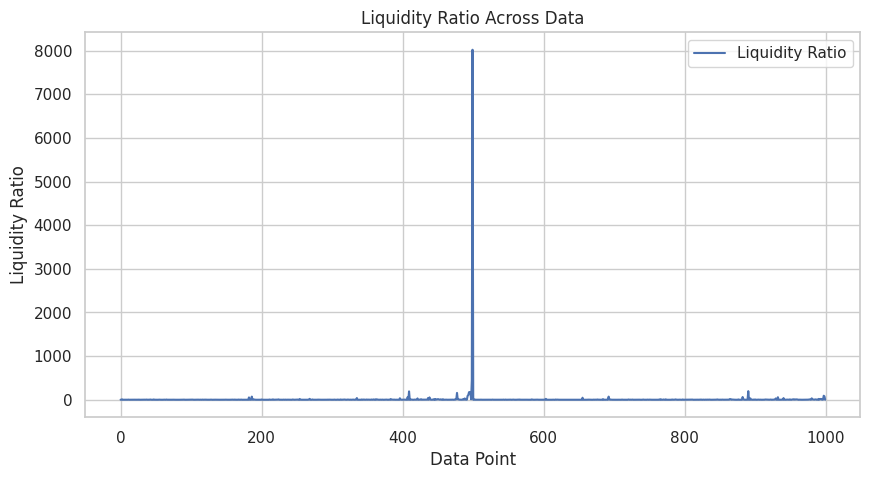

In [20]:
#  Liquidity Pattern Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df['liquidity_ratio'], label='Liquidity Ratio')
plt.title('Liquidity Ratio Across Data')
plt.xlabel('Data Point')
plt.ylabel('Liquidity Ratio')
plt.legend()
plt.show()

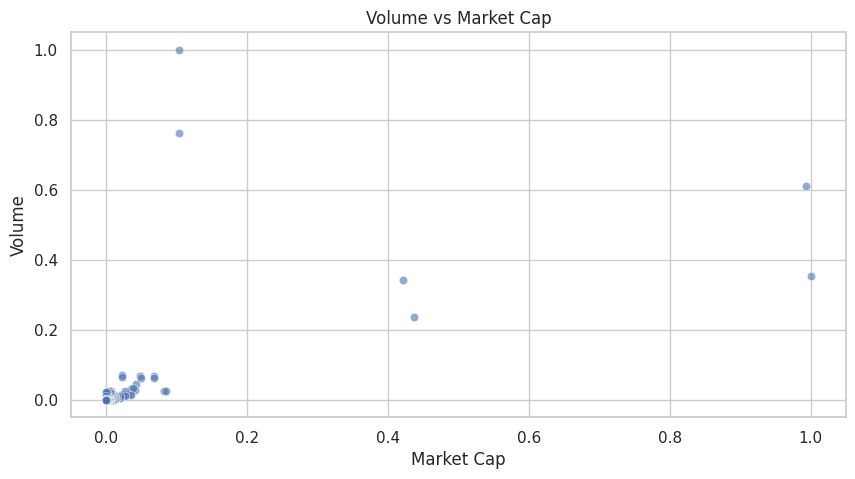

In [21]:
#  Volume vs Market Cap Trend
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['market_cap'], y=df['volume'], alpha=0.6)
plt.title('Volume vs Market Cap')
plt.xlabel('Market Cap')
plt.ylabel('Volume')
plt.show()

In [22]:
# STEP 6: MODEL TRAINING

# Define features and target

X = df[['price', 'volume', 'market_cap', 'price_change_1h',
        'price_change_24h', 'price_change_7d', 'price_ma_3',
        'volume_ma_3', 'price_volatility_3']]
y = df['liquidity_ratio']


# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Hyperparameter Tuning using GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


# Train best model

best_model = grid_search.best_estimator_

In [23]:
# STEP 7: MODEL EVALUATION

import math
y_pred = best_model.predict(X_test)
print("\nOptimized Model Evaluation:")
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


Optimized Model Evaluation:
RMSE: 555.8425014641327
MAE: 40.64482361526473
R^2 Score: 0.03417634618354526


In [29]:
import os
print(os.listdir())


['.config', 'crypto_cleaned_custom.csv', 'coin_gecko_2022-03-16.csv', 'coin_gecko_2022-03-17.csv', 'liquidity_model_optimized.pkl', 'sample_data']


In [24]:
# STEP 8: SAVE OPTIMIZED MODEL

joblib.dump(best_model, "liquidity_model_optimized.pkl")
print("\nOptimized model saved as 'liquidity_model_optimized.pkl'")


Optimized model saved as 'liquidity_model_optimized.pkl'


In [25]:
from google.colab import files
files.download("liquidity_model_optimized.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# STEP 9: MODEL TESTING & VALIDATION

# Compare predicted vs actual for sample

comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
print("\nSample Predictions vs Actual:")
print(comparison_df.head(10))


Sample Predictions vs Actual:
     Actual  Predicted
0  0.012950   0.137994
1  0.059509   0.063328
2  0.727525   1.986552
3  1.302455   1.298022
4  0.049211   0.075954
5  2.194688   2.152408
6  0.457378   0.484025
7  0.502592   0.987177
8  0.918374   0.983725
9  1.047372   1.190086


In [27]:
# STEP 9: SAVE CLEANED DATASET

df.to_csv("crypto_cleaned_custom.csv", index=False)
print("Cleaned dataset saved as 'crypto_cleaned_custom.csv'")

Cleaned dataset saved as 'crypto_cleaned_custom.csv'


In [30]:
# Create app.py

from flask import Flask, render_template, request
import joblib
import numpy as np

app = Flask(__name__)
model = joblib.load("liquidity_model_optimized.pkl")

@app.route('/')
def home():
    return render_template("index.html")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get values from form
        features = [float(x) for x in request.form.values()]
        prediction = model.predict([features])[0]
        return render_template("index.html", prediction_text=f"Predicted Liquidity Ratio: {prediction:.4f}")
    except:
        return render_template("index.html", prediction_text="Invalid input. Please enter numeric values.")

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


Flask App

http://127.0.0.1:5000
